![alt text](../img/header.jpg)

# Exercise x: Triangle
The purpose of this exercise is to use flopy and triangle to build a triangular mesh.

Part I. Setup Notebook

In [9]:
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
from flopy.utils.triangle import Triangle as Triangle
%matplotlib inline
#import config

#print(sys.version)
#print('python executable: {}'.format(sys.executable))
#print('numpy version: {}'.format(np.__version__))
#print('matplotlib version: {}'.format(mpl.__version__))
#print('flopy version: {}'.format(flopy.__version__))

In [21]:
# USA
mypoints = """11.6557716915961,66.9099099099099
11.4923730230223,63.0630630630631
10.7843121258693,60.4774774774775
9.42265655442116,56.6936936936937
8.38779832012057,53.7297297297297
8.00653476011509,50.7657657657658
7.13507519438828,49.2522522522523
7.46187253153583,47.3603603603604
7.29847386296205,44.9009009009009
8.38779832012057,42.1891891891892
8.49673076583642,39.2882882882883
9.04139299441568,37.2702702702703
9.31372410870531,34.4324324324324
11.1655756858748,33.6126126126126
12.8540285944705,31.9099099099099
13.5076232687656,29.5135135135135
16.8300628630991,28.1261261261261
22.5490162631813,24.3423423423423
27.3965100975367,23.5225225225225
27.5054425432525,24.1531531531532
29.9564225718592,24.1531531531532
32.5708012690396,21.0630630630631
33.2788621661927,18.8558558558559
35.1307137433621,17.3423423423423
36.2745044233786,18.7927927927928
37.4727613262529,18.8558558558559
38.6165520062694,18.3513513513514
40.4139373605809,15.009009009009
41.5577280405974,13.4324324324324
42.1568564920346,11.4774774774775
44.1721067377778,10.3423423423423
45.3158974177942,10.2162162162162
45.0980325263625,12.4864864864865
45.5882285320839,14.6306306306306
46.8409516578162,15.6396396396396
48.2026072292643,16.3333333333333
49.0740667949911,17.7837837837838
50.3267899207234,18.2252252252252
51.9063103836033,18.7297297297297
53.5402970693411,18.4144144144144
54.9019526407892,18.4774774774775
56.0457433208056,17.7207207207207
57.2984664465379,17.9099099099099
58.2788584579806,18.7297297297297
58.4422571265544,19.8648648648649
59.5315815837129,20.3693693693694
61.3834331608824,20.6216216216216
63.3442171837677,21
65.0326700923634,20.6216216216216
65.4683998752268,19.8018018018018
66.8845216695329,20.4324324324324
68.3551096866969,20.2432432432432
69.8801639267188,18.9189189189189
69.8801639267188,17.0900900900901
70.424826155298,15.6396396396396
71.4052181667407,14.5045045045045
72.4400764010413,12.9279279279279
73.6383333039157,11.6036036036036
74.5642590925004,12.1081081081081
74.83659020679,14.3783783783784
74.5642590925004,16.018018018018
73.5294008581998,17.972972972973
72.5490088467571,19.8018018018018
71.5686168353145,22.6396396396396
71.4052181667407,24.7207207207207
71.94988039532,25.981981981982
72.8213399610468,27.5585585585586
74.0740630867791,29.5765765765766
74.8910564296479,30.9009009009009
76.2527120010961,32.2882882882883
77.5054351268284,33.7387387387387
77.6143675725442,35.6306306306306
78.1590298011235,37.8378378378378
77.6143675725442,39.7297297297297
78.2679622468393,41.6216216216216
78.3768946925552,43.6396396396396
78.8126244754186,45.3423423423423
78.9215569211345,47.4234234234234
79.6840840411454,48.6846846846847
81.481469395457,50.3243243243243
82.897591189763,51.6486486486487
82.0805978468942,52.5315315315315
81.9171991783204,54.3603603603604
81.7538005097466,55.5585585585586
83.0065236354789,57.2612612612613
84.0958480926374,58.7117117117117
85.1851725497959,59.972972972973
83.4967196412002,61.2972972972973
82.7341925211893,63.9459459459459
81.3725369497411,64.3243243243243
80.4466111611564,63.3153153153153
80.3921449382985,60.6036036036036
79.8474827097192,58.7117117117117
75.6535835496589,57.0720720720721
74.4553266467845,55.3063063063063
73.8017319724894,53.3513513513513
70.9694883838773,52.4684684684685
71.1328870524511,50.7657657657658
69.716765258145,49.6936936936937
68.1372447952651,48.4324324324324
66.775589223817,47.2342342342342
65.6862647666585,47.990990990991
66.3943256638115,50.1981981981982
66.0130621038061,54.1711711711712
64.8148052009317,55.6846846846847
62.9084874009043,57.2612612612613
59.8039126980025,59.2162162162162
57.2984664465379,60.7927927927928
55.6100135379422,60.036036036036
53.8126281836307,60.036036036036
52.124175275035,60.2882882882883
50.3812561435813,60.6666666666667
49.0196005721332,61.2342342342342
47.9302761149747,61.6126126126126
40.0871400234334,61.9279279279279
31.6448754804549,62.6846846846847
24.5098002860666,64.1351351351351
17.59258998311,65.963963963964
14.0522854973449,67.036036036036
13.6165557144814,66.0900900900901
11.6557716915961,66.9099099099099"""
maximum_area = 1

In [11]:
# netherlands
mypoints = """214166.177410841,304076.125302918
207434.063703722,304409.365140479
197780.979475645,299938.43216301
186662.392574229,297179.691324579
184615.706244414,295462.48177268
178760.803552607,296482.689054549
167346.607410092,296123.525917202
152134.229731307,290273.222520518
144823.859191883,284777.064848319
140143.031109702,283056.092236773
135174.538023453,277220.422960935
128746.814029941,267954.097640944
125832.533392799,257664.220097177
125547.7952129,251149.527614063
127897.198785368,244638.598190595
128197.825439329,238124.741942958
125279.363624802,231263.429854652
126748.21124005,226808.385351245
132017.749097998,225787.341833899
136116.557288228,224764.6258456
139630.836880075,223055.360530731
141969.369391343,225458.701291461
144898.284149331,223748.599741116
141976.059275158,219972.996562724
140813.691962209,213114.193180848
140236.271365381,206599.082579996
140825.817376625,203171.353360012
144344.278145857,198033.522589682
142590.274232972,196316.731155521
137911.536739483,192881.475816244
133524.645427447,190132.351685798
131481.722157278,185329.433223984
124462.779681569,180862.263306161
114814.712866354,172277.05178214
113062.381424423,169188.834165794
113066.980719546,165417.412164787
110434.093320395,164385.079468503
104578.354393111,166090.999841464
107790.752977782,171924.16041087
109832.421894735,177755.648509323
109532.213358513,183926.648211414
107475.074085237,190780.852298167
106002.881528081,197978.749165942
107756.885440966,199695.540600103
110685.800198954,197985.439049758
114490.253501301,198333.731125904
118289.271273047,203139.158294149
122088.707162531,207601.728916849
121788.080508571,214115.585164486
118273.800916723,215824.850479355
114471.020085331,214105.132221024
110952.977433837,218900.106445807
109477.439934774,228840.855677952
105955.216105895,237064.395358196
99811.8121745432,234655.619066866
96888.3329471551,231908.585525112
91910.2231529213,233958.616796835
90734.4760723413,238071.222872434
86050.721165991,238750.246079711
84599.4344957587,228805.315670182
79939.5123005012,209941.515781331
78212.2679228782,186281.90543222
72094.7872913114,162616.023317033
64796.9602840413,146834.169278451
56326.3130203606,132764.925496645
47853.1570502491,120752.820988117
43757.2756841887,119375.541157594
42004.5261245189,116630.180086794
42889.6813768617,110802.873165726
44067.9371638725,104633.12781685
41144.039818746,102228.950820643
34414.4348180578,100505.051384928
31784.8923608147,96729.8663242747
29449.7047914551,91583.6731991756
22720.9360262439,89174.0606723682
18921.5001367593,84711.4900496689
10743.1171722697,70985.5209311482
5479.43296266034,67206.5728108487
5192.60419406935,62406.1630554652
8710.64684556299,57611.1888306816
12519.6994430323,54188.0589058208
18081.083482433,53853.1465973055
20715.2252347992,53856.9096569519
23938.4948806709,50775.8000421604
27161.3464088042,48037.5469729147
31260.5727167723,46671.974439069
35063.3535481646,48391.6926973995
37113.8029376255,47023.1933393842
34776.1066618351,43934.1394875615
32729.8384497588,41874.0733901158
25119.2593741126,42548.915420008
13405.690930852,47675.0388936605
8427.9992543567,49382.2136198368
530.173292381024,45599.5024398916
827.45500443379,41828.4985566227
-47.2473044472048,39084.3918390386
252.124996297916,33599.1052280399
4353.86001069685,30176.3934209174
9038.03303478565,29154.5136680945
11085.1374823389,30528.8666744483
11374.0568396222,33614.9937021014
14298.7904202257,35333.4576072169
22790.34357083,32259.8741117178
26889.1517610596,31237.1581234178
27188.5240618048,25751.8715124192
34507.2569559983,24390.8982736965
40064.4598180143,27484.5514206423
46498.873695342,31265.1720118956
53807.5717638123,38132.7558662789
57898.0175992725,43967.1707889013
64922.8137233211,43634.3490690782
69020.3675603353,43640.2027174166
69894.2336337393,47070.0225260933
66960.7195806279,52551.5460774456
74271.0901200521,58047.703749645
78083.4876594292,51881.7214604157
84230.236532689,51547.6453873773
88615.8734915096,55325.3391544614
90366.9505802255,59442.1264074454
93879.9758188575,58761.4307292148
93300.4646333369,53960.6028560927
91254.6145389991,51557.6802131006
93014.0539824843,48817.3365551628
98574.1836686696,49510.9938832859
100917.733592799,47800.0560974634
107637.721885502,57409.6560807383
111445.938247494,54672.2392469701
111161.200067596,48157.5467638559
113508.931169109,43018.0435225723
114684.678249689,38905.4374469729
119661.115572969,38226.832357435
120837.698889026,33428.5131907437
126107.654864713,32064.6131278518
130203.954348512,33099.0364128283
137226.659883868,34480.4974207361
140447.00270557,33799.383624767
142795.570042561,27974.1672923914
147774.516072272,25238.4229295764
153337.572582626,23532.0844388776
158608.782911528,21139.614739347
160367.804237275,18742.1276269553
158618.817737251,12911.057646241
155697.847216294,8106.88483121121
154245.724310585,-1152.33248722559
152498.410281515,-8354.82865012444
149579.112231512,-14530.4276473388
151050.886670929,-21385.4679695681
152227.051869248,-25840.930590713
156910.806775598,-26519.9537979897
164521.385851244,-27194.7958278819
170668.552842242,-27871.7284464662
175936.836346975,-27864.2023271735
174467.988731727,-23409.1578237666
173878.860838222,-20324.2851493291
175044.573093078,-16208.3341318222
177675.788021275,-13804.5752533533
177960.526201174,-7289.88277023881
174737.256555302,-4208.77315544765
174145.201837627,1276.09533781308
168290.717263559,1953.44607413593
165359.711916878,5377.83035221177
165062.430204825,9148.83423548038
168576.709796673,7439.56892061168
171204.579782962,12586.1801634491
182898.496692514,23574.3143304629
182893.897397391,27345.7363314701
177628.12259909,25281.0709389007
177620.596479797,31452.4887587304
181705.606784657,41744.0387734517
186379.326865284,49293.5726592809
185193.544958981,61634.7358279863
181963.167311555,70544.4067170614
178149.515418963,77738.9586429294
176972.513985167,82880.1343551665
172579.769024793,84931.001862366
172573.497258716,90073.8500455574
168763.190308031,94525.5496070563
167876.362584734,101724.282710309
173431.474858058,106532.218584985
179872.160501463,105169.990993047
179279.687666049,110997.716031854
183673.268861901,108261.135433562
187478.140281986,108266.570964162
190700.991810119,105528.317894917
195677.847251137,104506.856259832
196844.395741471,107937.094186247
201819.160593797,108629.915278893
209422.631667889,113783.634523285
214105.132221024,114133.180952646
219077.388366919,116883.141318569
222288.950716114,123402.014979068
219355.018545264,129226.395075967
214082.553863147,132647.434412135
216416.487079291,138822.197173872
220804.632744542,140542.75166768
226649.918728365,147408.244933371
230447.264029157,153585.098283801
235127.673993599,155648.927440893
233946.073264681,164561.525154138
235399.032405867,173135.029381482
232169.909111657,181016.130633919
229532.004299644,184098.076484187
226900.789371447,181694.317605718
219874.320776445,183398.565507726
212847.852181442,185102.813409733
211083.395325095,191957.435614224
214299.138851674,195047.743819262
212827.364412257,201902.784141491
218092.302975082,204653.162625152
224824.416682201,204319.922787591
232142.313340918,203644.662639961
233001.545293475,219074.46154275
233867.467129848,229018.555716802
238536.169797614,240682.368149185
239699.791463778,246512.601894422
239688.084167101,256112.585169712
238506.483438182,265025.182882957
239666.760162439,273598.268992563
238783.27738105,278054.149731447
232926.702218289,280445.7831955
231459.527073995,283529.401516722
227943.993128932,286267.236468229
219743.868042042,290369.807718105
217683.383826857,299966.864169226
214166.177410841,304076.125302918"""
maximum_area = 10000000

In [22]:
domainpoly = []
for line in mypoints.strip().split('\n'):
    x, y = line.strip().split(',')
    domainpoly.append((float(x), float(y)))

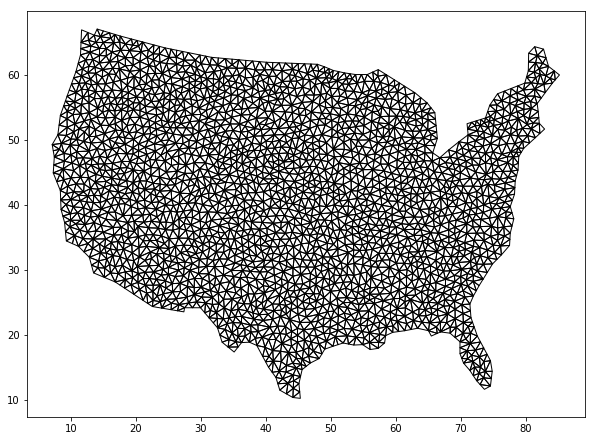

In [23]:
model_ws = './ex0x-completed-triangle'
if not os.path.exists(model_ws):
    os.makedirs(model_ws)

tri = Triangle(maximum_area=maximum_area, angle=30, model_ws=model_ws, 
               exe_name='triangle')
tri.add_polygon(domainpoly)
tri.build(verbose=False)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pc = tri.plot(ax=ax)

In [24]:
tri.ncpl

4411

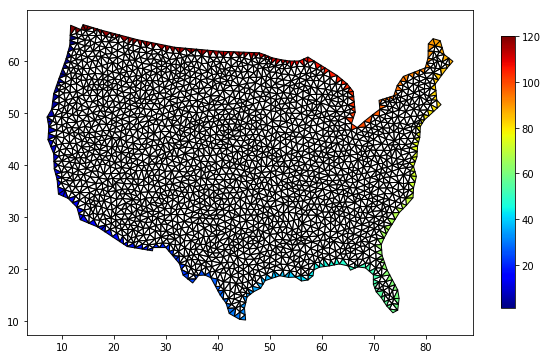

In [25]:
# this shows all the boundary cells
ibd = tri.get_boundary_marker_array()
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pc = tri.plot(a=ibd, cmap='jet')
plt.colorbar(pc, shrink=0.5)

In [26]:
edgenodes = []
for iedge in range(len(domainpoly)):
    nodes = tri.get_edge_cells(iedge)
    for n in nodes:
        if n not in edgenodes:
            edgenodes.append(n)

In [27]:
name = 'mf'
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name='mf6',
                             sim_ws=model_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             perioddata=[[1.0, 1, 1.]])
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex', 
                           outer_hclose=1.e-8, inner_hclose=1.e-8)
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1.
botm = [0.]
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, nvert=nvert,
                               top=top, botm=botm, 
                               vertices=vertices, cell2d=cell2d)
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[True], 
                              save_specific_discharge=True)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in edgenodes:
    h = 0.
    chdlist.append([(0, icpl), h])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])
sim.write_simulation()
success, buff = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 242 based on size of stress_period_data
    writing package rcha...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as n

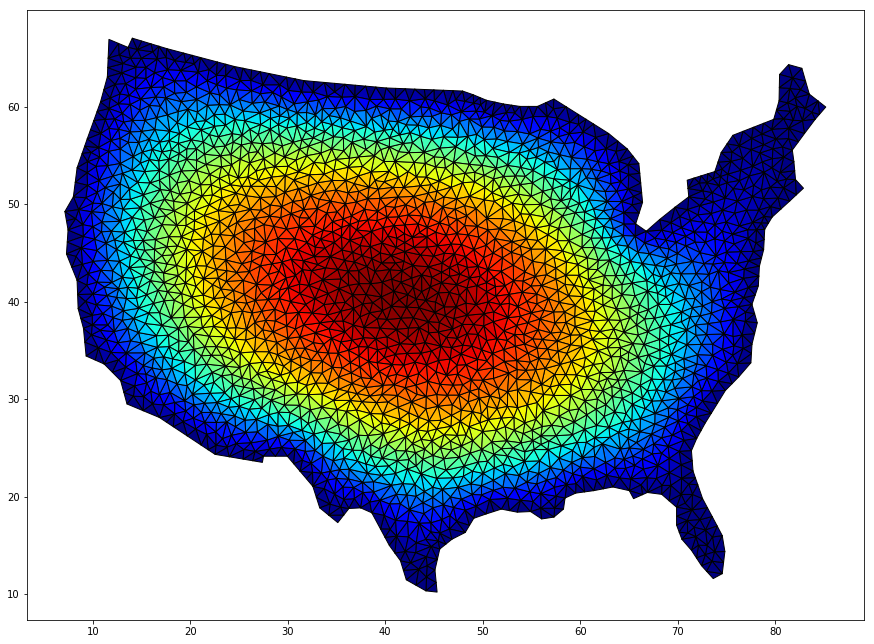

In [28]:
fname = os.path.join(model_ws, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
fname = os.path.join(model_ws, name + '.cbc')
bdobj = flopy.utils.CellBudgetFile(fname, precision='double', verbose=False)
spdis = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(ax=ax, a=head[0, 0, :], cmap='jet')

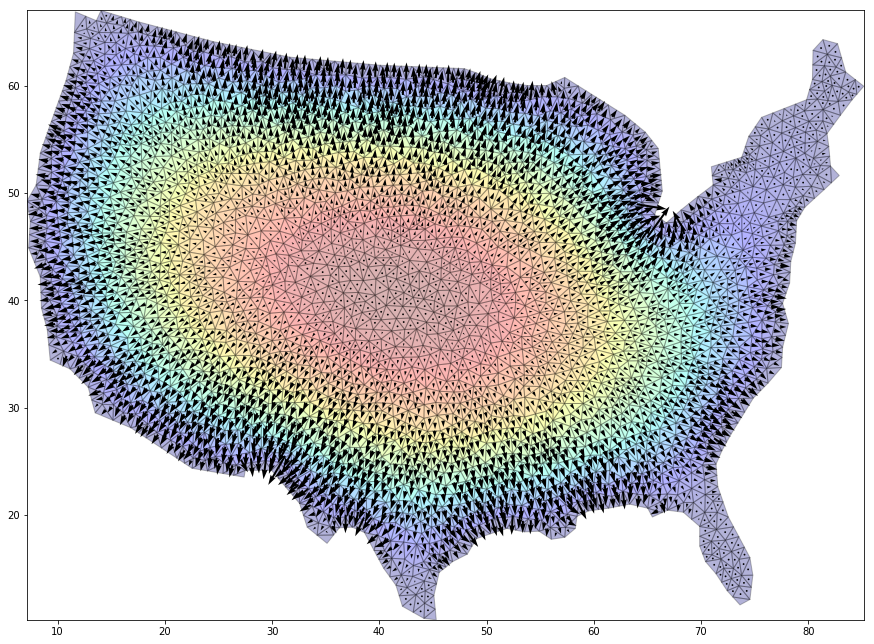

In [29]:
# with vectors
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_array(head[0, :, :], cmap='jet', edgecolor='0.1', alpha=0.3)
pmv.plot_specific_discharge(spdis)